In [11]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.timeseries import LombScargle

from scipy.optimize import curve_fit

from uncertainties import *

In [12]:
# Plot settings
plt.rc("font", size=10)
plt.rcParams['font.family'] = 'Liberation Serif'

In [13]:
# Functions
def gaussian(x, a, x0, sigma):
    return a * np.exp(-((x - x0)**2) / (2 * sigma**2))

def combine_light_curves(file_names):
    combined_time = []
    combined_flux = []

    for file_name in file_names:
        hdul = fits.open(f'data/{file_name}.fits')
        data = hdul[1].data
        time = data.field('TIME')
        flux = data.field('PDCSAP_FLUX')

        header = hdul[0].header
        date = header['DATE']
        print(f"OBSID {file_name} taken on {date}")

        # Remove NaN values
        mask = ~np.isnan(time) & ~np.isnan(flux)
        combined_time.append(time[mask])
        combined_flux.append(flux[mask])

    # Flatten the combined arrays and sort by time
    combined_time = np.concatenate(combined_time)
    combined_flux = np.concatenate(combined_flux)
    sorted_indices = np.argsort(combined_time)

    return combined_time[sorted_indices], combined_flux[sorted_indices]

def save_significant_frequencies_to_csv(significant_frequencies, file_name):
    formatted_data = []

    for freq in significant_frequencies:
        formatted_data.append({
            "frequency": f"{freq['frequency']:.5f}",
            "period": f"{freq['period']:.6f}",
            "power": f"{freq['power']:.5f}",
            "snr": f"{freq['snr']:.2f}",
            "fap": f"{freq['fap']:.2e}"
        })

    df = pd.DataFrame(formatted_data)
    df.to_csv(f'output/{file_name}.csv', index=False)
    print(f"Significant frequencies saved to {file_name}")

def analyze_light_curve(file_path_or_files, max_frequencies=4, max_frequency=10):
    """
    Analyze a light curve to detect significant frequencies of variability.

    Parameters:
    - file_path_or_files: str or list, path to the .dat file or list of FITS files containing light curve data.
    - max_frequencies: int, maximum number of significant frequencies to return.
    - max_frequency: float, maximum frequency to consider (cycles per day).

    Returns:
    - significant_frequencies: list of dicts with frequency, period, and significance metrics.
    """
    
    # Importing the data
    file_path_or_files_orig = file_path_or_files
    
    if isinstance(file_path_or_files, list):
        time, flux = combine_light_curves(file_path_or_files)

        sigma_range = 0.003
        offset_max = 3

        file_path_or_files = 'kplr'
    else:
        data = pd.read_csv(f'data/{file_path_or_files}.dat', sep=r'\s+', header=None, names=["time", "flux"])
        time = data["time"].values
        flux = data["flux"].values

        sigma_range = 0.003
        offset_max = 4

    # Performing Lomb-Scargle periodogram fitting
    frequency, power = LombScargle(time, flux).autopower(maximum_frequency=max_frequency)

    frequency_original = frequency.copy()
    power_original = power.copy()

    # It's here because of the not-gaussian form of the first peak for kepler-22
    if isinstance(file_path_or_files_orig, list):
        frequency = frequency[4:]
        power = power[4:]

    # Identifying significant frequencies
    significant_frequencies = []
    for _ in range(max_frequencies):
        max_power_idx = np.argmax(power)
        max_freq = frequency[max_power_idx]

        for range_offset in range(offset_max, 2, -1):
            # selecting points around the peak for gaussian fitting
            idx_range = slice(max(0, max_power_idx - range_offset), min(len(power), max_power_idx + range_offset + 1))
            freq_range = frequency[idx_range]
            power_range = power[idx_range]

            try:
                popt, pcov = curve_fit(gaussian, freq_range, power_range, 
                                       p0=[power[max_power_idx], max_freq, sigma_range])
                fitted_freq = popt[1]
                fitted_power = gaussian(fitted_freq, *popt)
                uncertainty = np.sqrt(np.diag(pcov))[1]  

                # Fit curve
                fit_freqs = np.linspace(freq_range[0], freq_range[-1], 100)
                fit_power = gaussian(fit_freqs, *popt)

                if fitted_freq <= 0:
                    raise RuntimeError("Fitted frequency is non-positive")
                
                break
            except RuntimeError:
                # If fit fails, try with a smaller range
                if range_offset == 3:
                    print(f'Gaussian fit failed for frequency: {max_freq:.5f} c/d')
                    fitted_freq = max_freq
                    fitted_power = power[max_power_idx]
                    uncertainty = np.nan
                    fit_freqs = freq_range
                    fit_power = power_range

        # Calculating SNR as the ratio of the peak power to the mean noise level
        noise_level = np.median(power)
        snr = fitted_power / noise_level

        # Estimating False Alarm Probability (FAP)
        fap = LombScargle(time, flux).false_alarm_probability(fitted_power)

        significant_frequencies.append({
            "frequency": ufloat(fitted_freq, uncertainty),
            "period": 1 / ufloat(fitted_freq, uncertainty),
            "power": fitted_power,
            "snr": snr,
            "fap": fap,
            "gaussian_fit": (fit_freqs, fit_power)
        })

        # Removing the points used for the gaussian fit
        power[idx_range] = 0
    
    save_significant_frequencies_to_csv(significant_frequencies, file_path_or_files)

    print("Significant Frequencies:")
    for freq in significant_frequencies:
        print(f"Frequency: {freq['frequency']:.5f} c/d, Period: {freq['period']:.6f} d, Power: {freq['power']:.5f}, SNR: {freq['snr']:.2f}, FAP: {freq['fap']:.2e}")

    # Plotting the lightcurve
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_xlabel('Time (days)')
    ax.yaxis.label.set_fontsize(20)
    ax.set_ylabel('Flux')
    ax.xaxis.label.set_fontsize(20)
    ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
    ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
    plt.tight_layout()  
    
    ax.plot(time, flux, color='blue', marker='o', linestyle='-', linewidth=0.5, markersize=2)

    plt.savefig(f'images/{file_path_or_files}_ls.png', bbox_inches='tight')
    # plt.show()
    plt.close()

    # Plotting the periodogram
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_xlabel('Frequency (cycles/day)')
    ax.yaxis.label.set_fontsize(20)
    ax.set_ylabel('Power')
    ax.xaxis.label.set_fontsize(20)
    ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
    ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)

    if isinstance(file_path_or_files_orig, list):
        ax.set_xlim(-0.001, (lambda x: x.n)(significant_frequencies[-1]["frequency"])+0.02)

    # # Plotting single frequency gaussian fit
    # if file_path_or_files == 1:
    #     ax.set_xlim((lambda x: x.n)(significant_frequencies[0]["frequency"])-0.01, (lambda x: x.n)(significant_frequencies[0]["frequency"])+0.01)

    # xx = 0
    # ax.set_xlim((lambda x: x.n)(significant_frequencies[xx]["frequency"])-0.005, (lambda x: x.n)(significant_frequencies[xx]["frequency"])+0.005)

    plt.tight_layout()  

    ax.plot(frequency_original, power_original)
    
    ax.axhline(noise_level, color='red', linestyle='-', label=f"Noise Level = {noise_level:.2g}")

    colours = ['green', 'orange', 'purple', 'brown']
    counter = 0
    for freq in significant_frequencies:
        ax.axvline((lambda x: x.n)(freq["frequency"]), color=colours[counter], linestyle='--', label=f"f={freq['frequency']:.5f}")
        
        # # Plotting single frequency gaussian fit
        # if file_path_or_files == 1:
        #     fit_freqs, fit_power = freq["gaussian_fit"]
        #     ax.plot(fit_freqs, fit_power, color='red', linestyle='-')
        #     break

        counter += 1

    ax.legend(fontsize=15)

    # # Saving single frequency gaussian fit
    # if file_path_or_files == 1:
    #     plt.savefig(f'images/{file_path_or_files}_ls_gaussian.png', bbox_inches='tight')

    plt.savefig(f'images/{file_path_or_files}_per.png', bbox_inches='tight')
    plt.show()
    # plt.close()

    return significant_frequencies

OBSID kplr010593626-2009131105131_llc taken on 2015-08-26
OBSID kplr010593626-2009166043257_llc taken on 2015-09-01
OBSID kplr010593626-2009259160929_llc taken on 2015-09-06
OBSID kplr010593626-2009350155506_llc taken on 2015-09-09
OBSID kplr010593626-2010078095331_llc taken on 2015-09-11
Significant frequencies saved to kplr
Significant Frequencies:
Frequency: 0.00365+/-0.00009 c/d, Period: 273.652652+/-7.084234 d, Power: 0.76188, SNR: 453288.20, FAP: 0.00e+00
Frequency: 0.00727+/-0.00015 c/d, Period: 137.642236+/-2.923055 d, Power: 0.17266, SNR: 102834.19, FAP: 0.00e+00
Frequency: 0.01711+/-0.00013 c/d, Period: 58.439707+/-0.437839 d, Power: 0.05722, SNR: 34123.54, FAP: 4.26e-179
Frequency: 0.01380+/-0.00011 c/d, Period: 72.470656+/-0.578212 d, Power: 0.05108, SNR: 30538.71, FAP: 7.65e-159


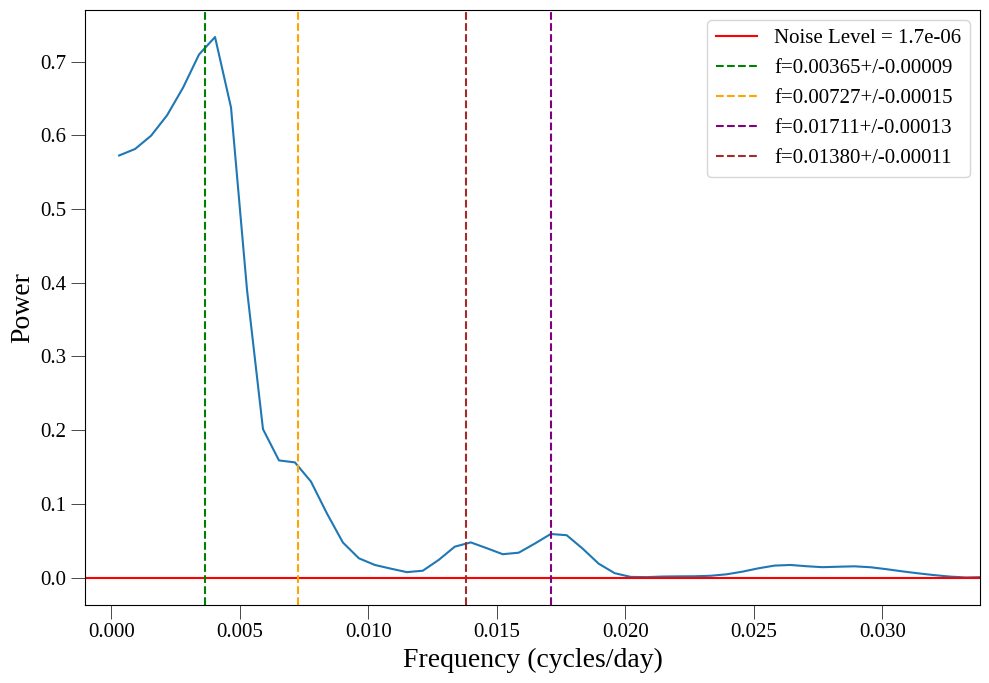

In [14]:
# Periodogram for Kepler-22b
freq_kepler22 = analyze_light_curve(['kplr010593626-2009131105131_llc', 'kplr010593626-2009166043257_llc', 'kplr010593626-2009259160929_llc', 'kplr010593626-2009350155506_llc', 'kplr010593626-2010078095331_llc'], max_frequencies=4, max_frequency=10)

Significant frequencies saved to 1
Significant Frequencies:
Frequency: 4.96799+/-0.00003 c/d, Period: 0.201289+/-0.000001 d, Power: 0.47765, SNR: 95.13, FAP: 1.77e-164
Frequency: 5.96816+/-0.00002 c/d, Period: 0.167556+/-0.000001 d, Power: 0.41957, SNR: 83.72, FAP: 3.78e-137
Frequency: 3.96781+/-0.00001 c/d, Period: 0.252028+/-0.000001 d, Power: 0.35065, SNR: 70.13, FAP: 4.53e-108
Frequency: 4.73144+/-0.00004 c/d, Period: 0.211352+/-0.000002 d, Power: 0.31980, SNR: 64.12, FAP: 4.80e-96


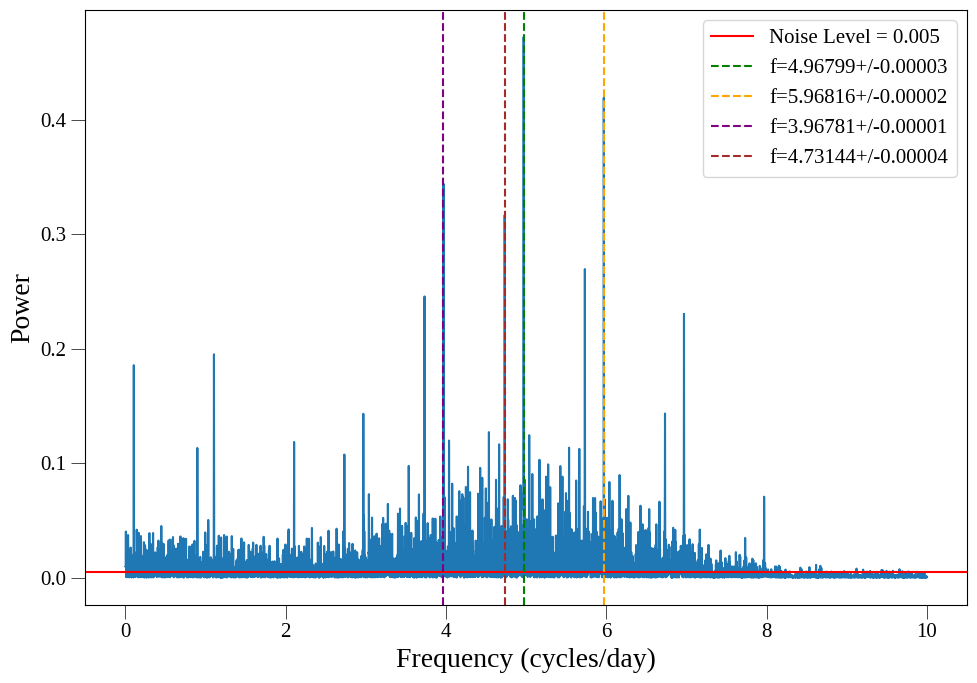

In [15]:
# Periodogram for 1.dat
freq_1 = analyze_light_curve(1, max_frequencies=4, max_frequency=10)

Significant frequencies saved to 2
Significant Frequencies:
Frequency: 3.04011+/-0.00003 c/d, Period: 0.328936+/-0.000003 d, Power: 0.31660, SNR: 116.35, FAP: 7.90e-95
Frequency: 2.04010+/-0.00003 c/d, Period: 0.490173+/-0.000008 d, Power: 0.27371, SNR: 100.86, FAP: 4.55e-79
Frequency: 1.91750+/-0.00002 c/d, Period: 0.521512+/-0.000004 d, Power: 0.27641, SNR: 102.19, FAP: 4.97e-80
Frequency: 2.91746+/-0.00001 c/d, Period: 0.342763+/-0.000002 d, Power: 0.27322, SNR: 101.13, FAP: 6.82e-79


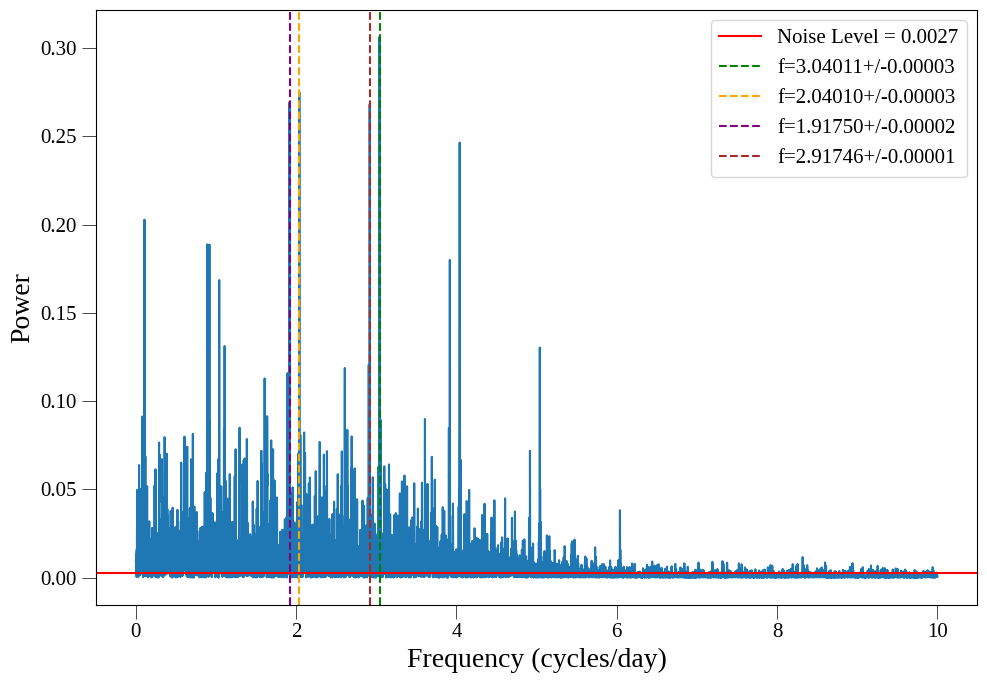

In [16]:
# Periodogram for 2.dat
freq_2 = analyze_light_curve(2, max_frequencies=4, max_frequency=10)

Significant frequencies saved to 3
Significant Frequencies:
Frequency: 2.35215+/-0.00002 c/d, Period: 0.425143+/-0.000004 d, Power: 0.51282, SNR: 143.00, FAP: 1.51e-182
Frequency: 1.35207+/-0.00003 c/d, Period: 0.739606+/-0.000015 d, Power: 0.43737, SNR: 122.07, FAP: 3.19e-145
Frequency: 3.35219+/-0.00002 c/d, Period: 0.298312+/-0.000002 d, Power: 0.40175, SNR: 112.51, FAP: 2.61e-129
Frequency: 3.50091+/-0.00002 c/d, Period: 0.285640+/-0.000002 d, Power: 0.30387, SNR: 85.28, FAP: 4.76e-90


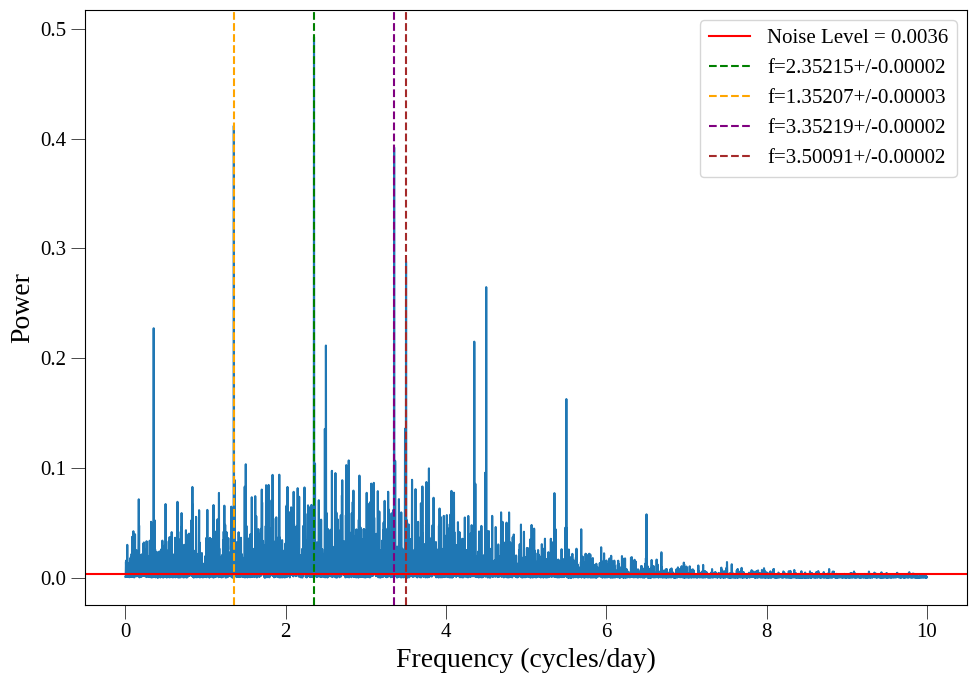

In [17]:
# Periodogram for 3.dat
freq_3 = analyze_light_curve(3, max_frequencies=4, max_frequency=10)

Significant frequencies saved to 4
Significant Frequencies:
Frequency: 1.83302+/-0.00002 c/d, Period: 0.545547+/-0.000006 d, Power: 0.46537, SNR: 125.84, FAP: 1.88e-158
Frequency: 0.83299+/-0.00004 c/d, Period: 1.200492+/-0.000059 d, Power: 0.42233, SNR: 114.49, FAP: 2.20e-138
Frequency: 2.83304+/-0.00002 c/d, Period: 0.352978+/-0.000002 d, Power: 0.37179, SNR: 101.09, FAP: 1.20e-116
Frequency: 3.92692+/-0.00004 c/d, Period: 0.254652+/-0.000002 d, Power: 0.32239, SNR: 87.85, FAP: 4.91e-97


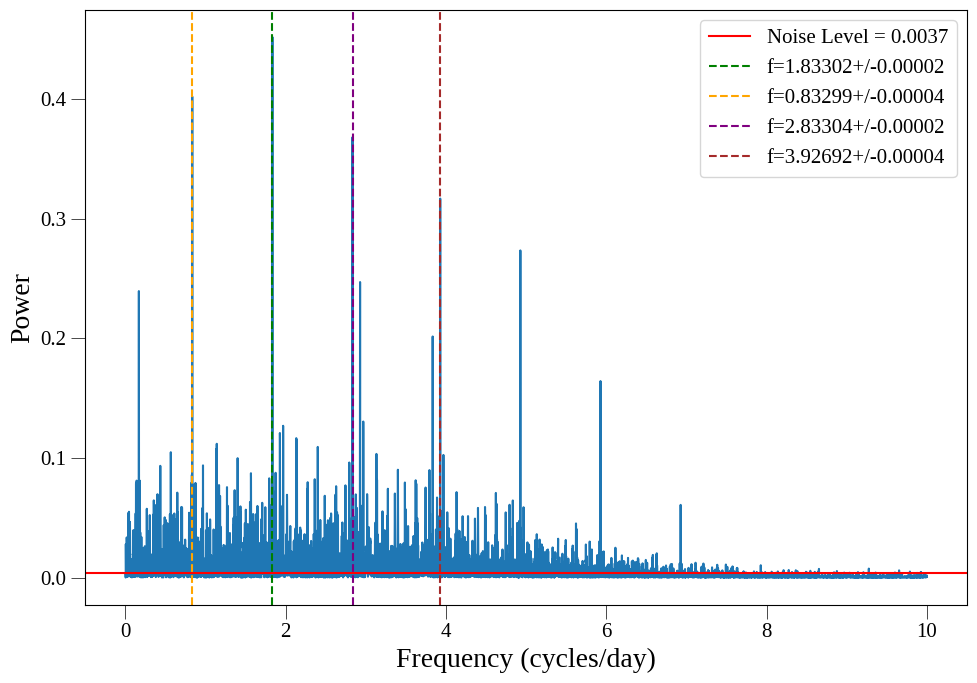

In [18]:
# Periodogram for 4.dat
freq_4 = analyze_light_curve(4, max_frequencies=4, max_frequency=10)

Significant frequencies saved to 5
Significant Frequencies:
Frequency: 7.62956+/-0.00002 c/d, Period: 0.131069+/-0.000000 d, Power: 0.25523, SNR: 65.01, FAP: 1.46e-72
Frequency: 6.62965+/-0.00002 c/d, Period: 0.150837+/-0.000000 d, Power: 0.23426, SNR: 59.81, FAP: 2.23e-65
Frequency: 8.62947+/-0.00003 c/d, Period: 0.115882+/-0.000000 d, Power: 0.19892, SNR: 50.89, FAP: 1.05e-53
Frequency: 7.83749+/-0.00007 c/d, Period: 0.127592+/-0.000001 d, Power: 0.17241, SNR: 44.20, FAP: 2.75e-45


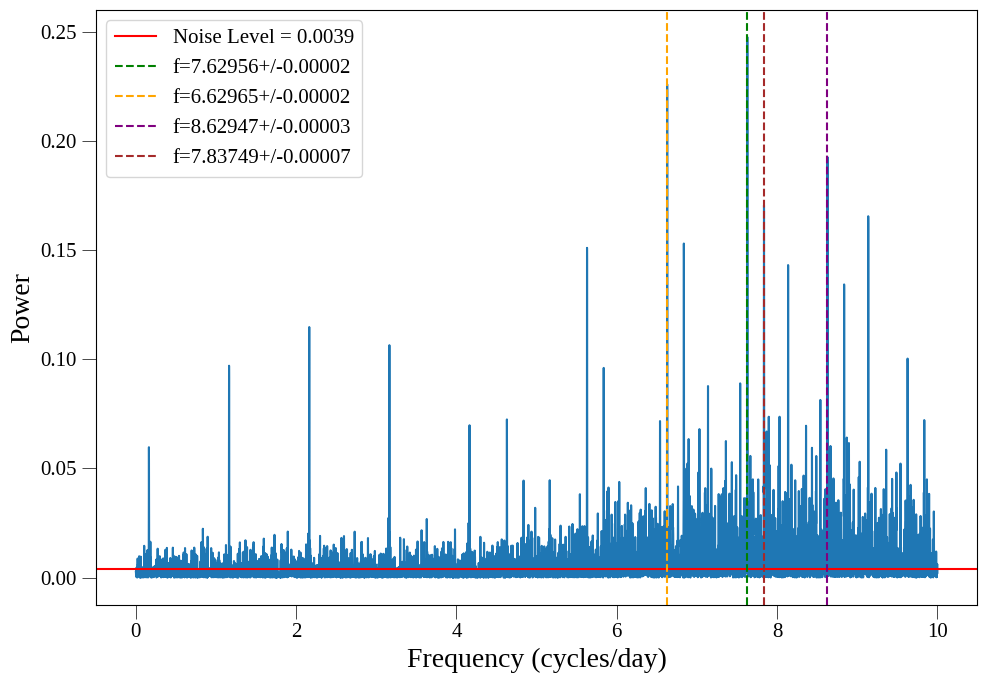

In [19]:
# Periodogram for 5.dat
freq_5 = analyze_light_curve(5, max_frequencies=4, max_frequency=10)

Significant frequencies saved to 6
Significant Frequencies:
Frequency: 1.75607+/-0.00004 c/d, Period: 0.569454+/-0.000014 d, Power: 0.39830, SNR: 131.70, FAP: 8.06e-128
Frequency: 0.75601+/-0.00004 c/d, Period: 1.322726+/-0.000075 d, Power: 0.36538, SNR: 121.14, FAP: 5.13e-114
Frequency: 2.75612+/-0.00003 c/d, Period: 0.362828+/-0.000003 d, Power: 0.30961, SNR: 102.89, FAP: 3.40e-92
Frequency: 0.24393+/-0.00006 c/d, Period: 4.099592+/-0.000936 d, Power: 0.24554, SNR: 81.95, FAP: 3.23e-69


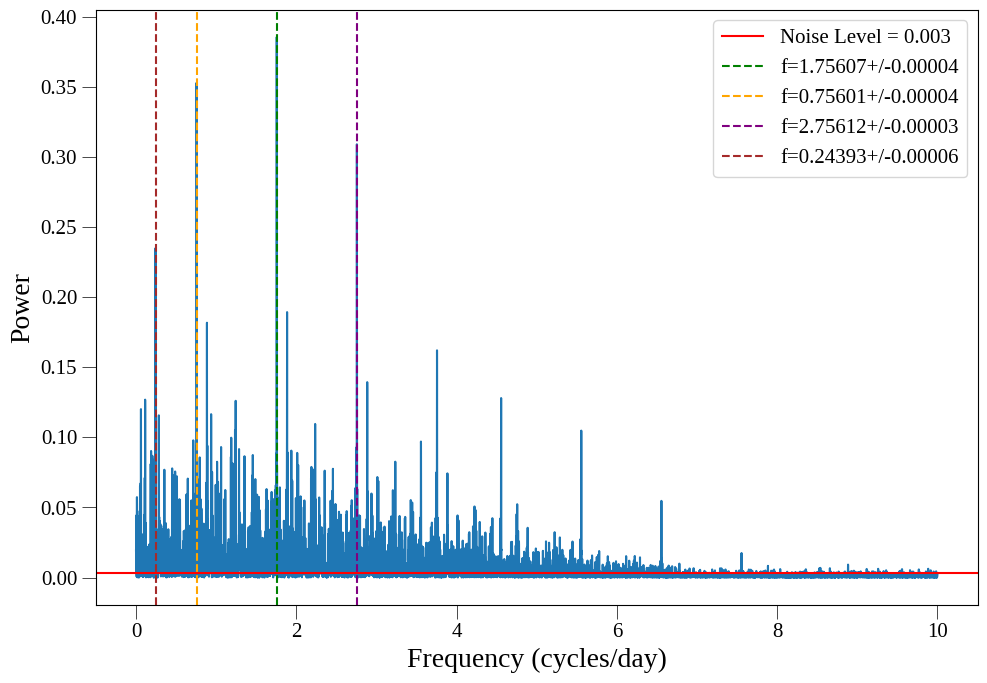

In [20]:
# Periodogram for 6.dat
freq_6 = analyze_light_curve(6, max_frequencies=4, max_frequency=10)